In [1]:
import pandas as pd
import numpy, os
import matplotlib.pyplot as plt

In [2]:
def load_clap_df(number_of_claps: str) -> pd.DataFrame:
    df = pd.DataFrame() # create an empty DataFrame to store the data
    dir_path = os.path.join(os.getcwd(), "recordings")
    for file_name in os.listdir(dir_path):# iterate over the files in the directory
        if file_name[0] == number_of_claps:# check if the file name starts with the specified number of claps the files are xClaps_baudRate_numberOfFile
            file_path = os.path.join(dir_path, file_name)
            df = pd.concat([df, pd.read_csv(file_path,header=None,names=[file_name[:-4]])], axis=1)
    df.dropna(inplace=True) # drop any rows with missing values cuase by the length of the recordings
    df = df.astype(int)
    return df

In [3]:
#create a line plot with y axis from 0-2^10-1 (the possible analog values)
def line_plot(df: pd.DataFrame, title: str):
    df.plot(kind = "line")
    plt.xlabel('Sample number')
    plt.ylabel('Microphone value')
    plt.title(title)
    plt.ylim(0,1023)
    plt.show()


In [4]:
#load the dataframes by the number of the claps in the recordings
df0claps = load_clap_df("0")
df1claps = load_clap_df("1")
df2claps = load_clap_df("2")

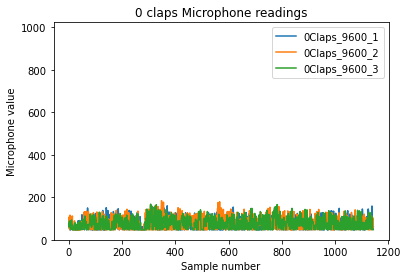

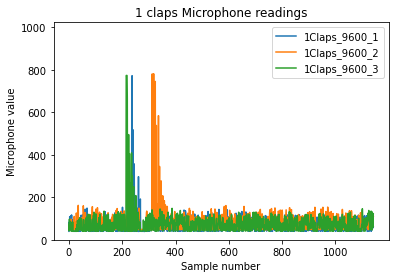

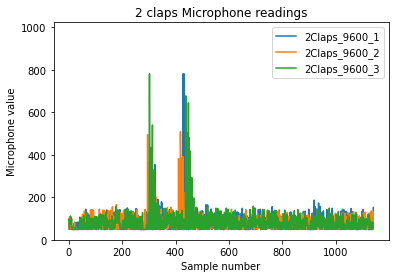

In [5]:
#ploting the dataframes
line_plot(df0claps,'0 claps Microphone readings')
line_plot(df1claps,'1 claps Microphone readings')
line_plot(df2claps,'2 claps Microphone readings')


In [6]:
#checking the mean of no claps 
df0claps.mean() #around 77

0Claps_9600_1    76.472028
0Claps_9600_2    78.360140
0Claps_9600_3    77.686189
dtype: float64

In [7]:
#checking in 1 claps recordings the max ratio between short-term mean to long-term mean sliding window
rolling_short_mean = df1claps.rolling(window=32, min_periods=1).mean()
max_short_mean = rolling_short_mean.max()
print(max_short_mean)
print(max_short_mean.mean())

rolling_long_mean = df1claps.rolling(window=256, min_periods=1).mean()
max_long_mean = rolling_long_mean.max()
print(max_long_mean)
print(max_long_mean.mean())
print((rolling_short_mean/rolling_long_mean).max())

1Claps_9600_1    144.4375
1Claps_9600_2    247.5000
1Claps_9600_3    240.3750
dtype: float64
210.77083333333334
1Claps_9600_1     84.454545
1Claps_9600_2    102.550781
1Claps_9600_3     98.390625
dtype: float64
95.13198390151514
1Claps_9600_1    1.981034
1Claps_9600_2    2.491741
1Claps_9600_3    2.672998
dtype: float64


In [8]:
#checking in 2 claps recordings the max ratio between short-term mean to long-term mean sliding window
rolling_short_mean = df2claps.rolling(window=32, min_periods=1).mean()
max_short_mean = rolling_short_mean.max()
print(max_short_mean)
print(max_short_mean.mean())

rolling_long_mean = df2claps.rolling(window=256, min_periods=1).mean()
max_long_mean = rolling_long_mean.max()
print(max_long_mean)
print(max_long_mean.mean())
print((rolling_short_mean/rolling_long_mean).max())

2Claps_9600_1    222.06250
2Claps_9600_2    141.18750
2Claps_9600_3    196.28125
dtype: float64
186.51041666666666
2Claps_9600_1    105.703125
2Claps_9600_2     97.000000
2Claps_9600_3    109.546875
dtype: float64
104.08333333333333
2Claps_9600_1    2.217334
2Claps_9600_2    1.512895
2Claps_9600_3    1.920637
dtype: float64


In [9]:
#trynig to check matches we will get between the short-term mean to long-term mean
long_window = df1claps.iloc[:,1].rolling(window=256, min_periods=1)

short_window = df1claps.iloc[:,1].rolling(window=32, min_periods=1)

long_window_mean = long_window.mean()
short_window_mean = short_window.mean()
ratio = short_window_mean / long_window_mean

num_windows = (ratio > 1.5).sum()

print("Number of Long Windows:", num_windows)
#we get more than 1 because when the first one match its likely the next window also match



Number of Long Windows: 38


In [10]:
#trynig to write algoritem that will work with real time data
def clap_detction(series: pd.Series):
    in_clap= -1
    claps=0
    sample = [77]*256
    long_sum = 77*256
    short_sum = 77*32
    max_short_sum = 77
    for i,value in enumerate(series):
        short_sum += value-sample[-32]
        long_sum += value-sample[0]
        max_short_sum = max(max_short_sum,value)
        if(max_short_sum == sample[-32]):
            max_short_sum = max(sample[-31:])

        sample.pop(0)
        sample.append(value)

        clap_likeness = (short_sum >> 5)/(long_sum >> 8)
        if (in_clap > 0):
            in_clap-=1
        elif(clap_likeness>1.5 and max_short_sum > 600):
            print(f"max in the short sum {max_short_sum}")
            print(f"found clap on {i} value")
            in_clap = 64
            claps+=1
    return claps


In [11]:
clap_detction(df1claps.iloc[:,2])

max in the short sum 773
found clap on 216 value


1

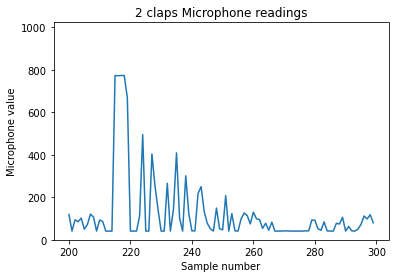

In [12]:
line_plot(df1claps.iloc[200:300,2],'2 claps Microphone readings')

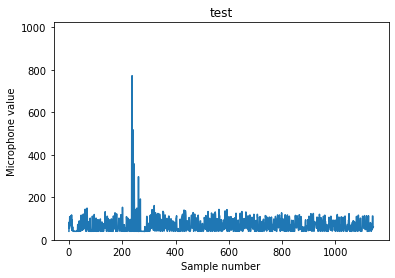

max in the short sum 772
found clap on 240 value


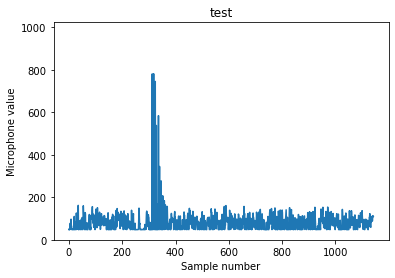

max in the short sum 781
found clap on 318 value


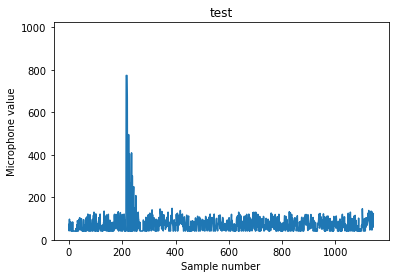

max in the short sum 773
found clap on 216 value


In [13]:
for df in df1claps:
    line_plot(df1claps[df],"test")
    clap_detction(df1claps[df])

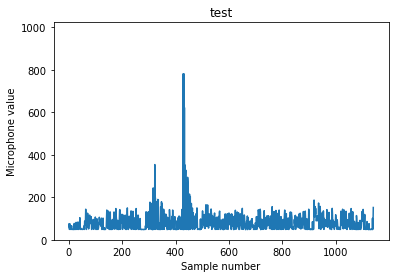

max in the short sum 781
found clap on 431 value


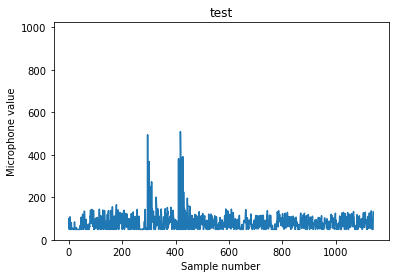

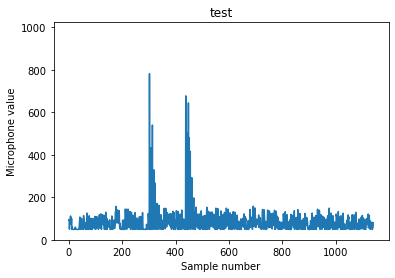

max in the short sum 781
found clap on 313 value
max in the short sum 677
found clap on 453 value


In [14]:
for df in df2claps:
    line_plot(df2claps[df],"test")
    clap_detction(df2claps[df])

we can see that not all the claps were detected because most of the peaks were to small 